In [1]:
import pandas as pd
import pandahouse as ph
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
%matplotlib inline

In [2]:
#Settings for graphs
sns.set(rc={'figure.figsize':(11.7,8.27)})

In [3]:
connection = {'host': 'https://clickhouse.lab.karpov.courses',
                      'database':'********************',
                      'user':'********', 
                      'password':'**********'
                     }

In [4]:
# SQL query
q = """
SELECT exp_group,
    user_id,
    sum(action = 'like') as likes,
    sum(action = 'view') as views,
    likes/views as ctr
FROM {db}.feed_actions
WHERE toDate(time) >= '2023-01-24' and toDate(time) <= '2023-01-30'
    and exp_group in (2,3)
GROUP BY exp_group, user_id
"""

In [5]:
df = ph.read_clickhouse(q, connection=connection)

In [6]:
# DataFrame extracted from DB by SQL query
df

,exp_group,user_id,likes,views,ctr
0,3,115383,11,36,0.305556
1,3,123580,15,92,0.163043
2,2,131473,26,148,0.175676
3,2,23985,12,66,0.181818
4,2,24523,17,120,0.141667
...,...,...,...,...,...
17044,3,122008,4,31,0.129032
17045,2,25383,16,57,0.280702
17046,3,122190,25,74,0.337838
17047,2,108927,8,33,0.242424


Построим графики распределений пользовательских CTR для групп 2 и 3:

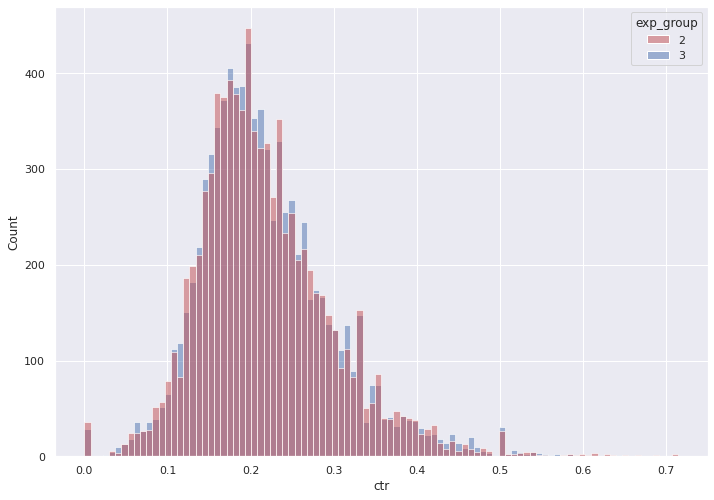

In [7]:
groups = sns.histplot(data = df,
x='ctr',
hue='exp_group',
palette = ['r', 'b'],
alpha=0.5,
kde=False)

<AxesSubplot:xlabel='exp_group', ylabel='ctr'>

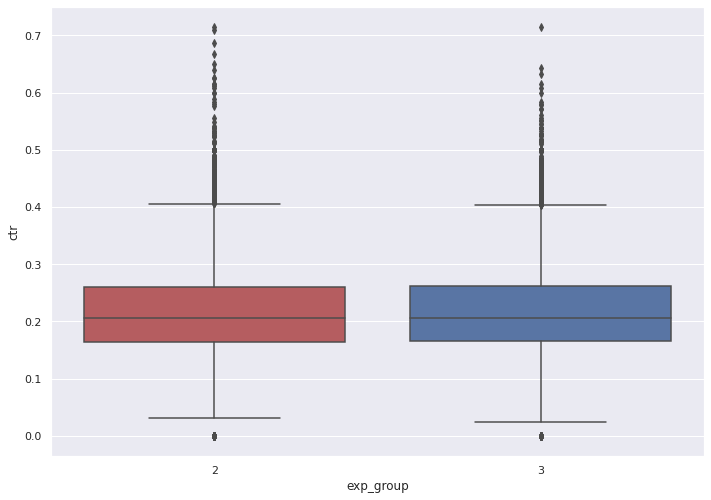

In [8]:
sns.boxplot(data=df, y='ctr', x='exp_group', palette = ['r', 'b'])

Визуально распредления значений CTR для групп 2 и 3, а также средние (медианные) значения выглядят практически одинаковыми. Характер распределений для групп близок к нормальному, можем воспользоваться t-testом для проверки гипотезы о равенстве средних значений этих двух выборок. Примем уровень статистической значимости равным 5% (0.05):

In [9]:
alpha = 0.05

<b>AA-тест</b>

1. Для 10000 случайных выборок проведем оценку в скольки % случаях случайно выбранное значение пользовательского CTR из группы 2 больше, чем случайно выбранное значение из группы 3:

In [10]:
A_gt_B = 0
for _ in range(10000):
    A_gt_B+= df[df.exp_group == 2].ctr.sample().values[0] > df[df.exp_group == 3].ctr.sample().values[0]

В случае, если значимых различий между группами 2 и 3 нет, получим значение близкое к 50%:

In [11]:
print(A_gt_B/100, '%')

49.51 %


2. Сравним распределения пользовательских CTR для групп 2 и 3 при помощи t-test:

In [12]:
stats.ttest_ind(df[df.exp_group == 2].ctr,
                df[df.exp_group == 3].ctr,
                equal_var=False)

Ttest_indResult(statistic=-0.7393597924958364, pvalue=0.45969873156476293)

3. Выполним симуляцию 10000 АА-тестов. На каждой итерации сформируем подвыборки без повторения в 500 юзеров из 2 и 3 экспериментальной группы. Проведем сравнение этих подвыборок t-testом. 

In [13]:
t_scores = []
p_values = []
for _ in range(10000):
    t_score, p_value = stats.ttest_ind(df[df.exp_group == 2].sample(n=500, replace=False).ctr,
                df[df.exp_group == 3].sample(n=500, replace=False).ctr,
                equal_var=False)
    
    # Adding each p-value from 10000 t-test iterations to array: 
    p_values.append(p_value)
    t_scores.append(t_score)

Построим график получившегося распределения 10000 значений t_score:

Text(0, 0.5, 'frequency')

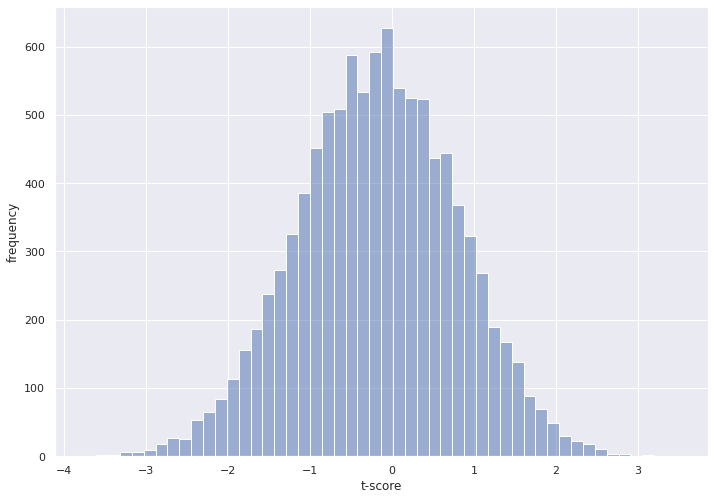

In [14]:
ax = plt.subplots()
ax = sns.histplot(data = t_scores,
                    bins=50,
                    alpha=0.5,
                    legend=True,
                    kde=False)
ax.set_xlabel("t-score")
ax.set_ylabel("frequency")

Построим график получившегося распределения 10000 значений p-value:

Text(0, 0.5, 'frequency')

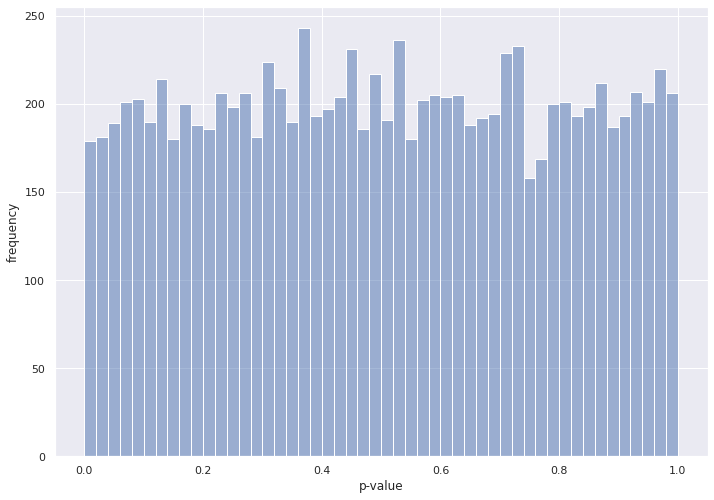

In [15]:
hist, ax = plt.subplots()
ax = sns.histplot(data = p_values,
                    bins=50,
                    alpha=0.5,
                    legend=True,
                    kde=False)
ax.set_xlabel("p-value")
ax.set_ylabel("frequency")

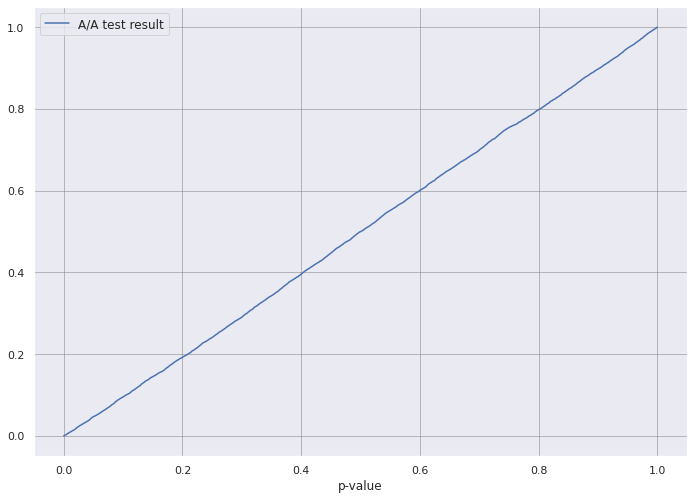

In [16]:
def plot_pvalue_distribution(pvalues_aa, alpha):
    X = np.linspace(0, 1, 1000)
    Y_aa = [np.mean(pvalues_aa < x) for x in X]
    
    plt.plot(X, Y_aa, label='A/A test result')
    
    plt.xlabel('p-value', size=12)
    plt.legend(fontsize=12)
    plt.grid(color='grey', linestyle='-', linewidth=0.5)
    plt.show()

plot_pvalue_distribution(p_values, alpha)

Из графиков видим, что p-values распределены равномерно в диапазоне от 0 до 1.

Оценим долю p-values, которые меньше либо равны 0.05:

In [17]:
# Count of p values <= 0.05
p_val_lim = 0
for i in p_values:
    if i <= 0.05:
        p_val_lim += 1
p_val_lim

469

In [18]:
print('Процент p values <= 0.05:', p_val_lim / len(p_values) * 100,'%')

Процент p values <= 0.05: 4.6899999999999995 %


Оценим доверительный интервал:

In [19]:
def print_estimated_errors(pvalues_aa, alpha):
    # Estimation the probability of errors
    estimated_first_type_error = np.mean(pvalues_aa < alpha)
    ci_first = estimate_ci_bernoulli(estimated_first_type_error, len(pvalues_aa))
    print(f'Оценка вероятности ошибки I рода = {estimated_first_type_error:0.4f}')
    print(f'Доверительный интервал = [{ci_first[0]:0.4f}, {ci_first[1]:0.4f}]')

In [20]:
def estimate_ci_bernoulli(p, n, alpha=0.05):
    # Confidence interval for a Bernoulli random variable
    t = stats.norm.ppf(1 - alpha / 2, loc=0, scale=1)
    std_n = np.sqrt(p * (1 - p) / n)
    return p - t * std_n, p + t * std_n

In [21]:
pvalues_aa = np.array(p_values)
print_estimated_errors(pvalues_aa, alpha)

Оценка вероятности ошибки I рода = 0.0469
Доверительный интервал = [0.0428, 0.0510]


<b>Вывод:</b> доля p-values <= 0.05 составляет менее 5%, следовательно, с учетом принятого уровня статистической значимости = 5%, различия между средними значениями CTR групп 2 и 3 не являются статистически значимыми, а значит система сплитования аботает корректно. Указанные группы принимаем одинаковыми и подтверждаем возможность их использования для AB-тестирования.